<a href="https://colab.research.google.com/github/kundanmishra/MachineLearning/blob/master/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing required libraries

In [ ]:
# Importing required libraries
# conda install -c conda-forge scikit-plot
# conda install -c conda-forge wordcloud
import json
import tensorflow as tf
import requests
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt;

# Get the dataset

In [ ]:
# Get the dataset
pd.set_option('max_colwidth', 100)
sarcasm = pd.read_json("./Sarcasm_Headlines_Dataset_v2.json", lines=True)
sarcasm.head()


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clock of hair loss,https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html
3,1,inclement weather prevents liar from getting to work,https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031
4,1,mother comes pretty close to using word 'streaming' correctly,https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546


In [ ]:
sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
sarcasm.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# Some basic EDA

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

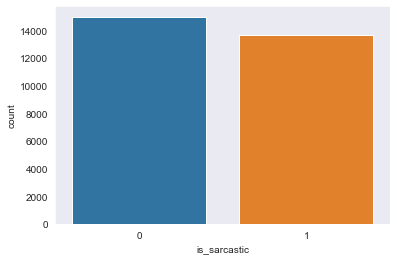

In [ ]:
sns.set_style("dark")
sns.countplot(sarcasm.is_sarcastic)

In [ ]:
from wordcloud import WordCloud,STOPWORDS

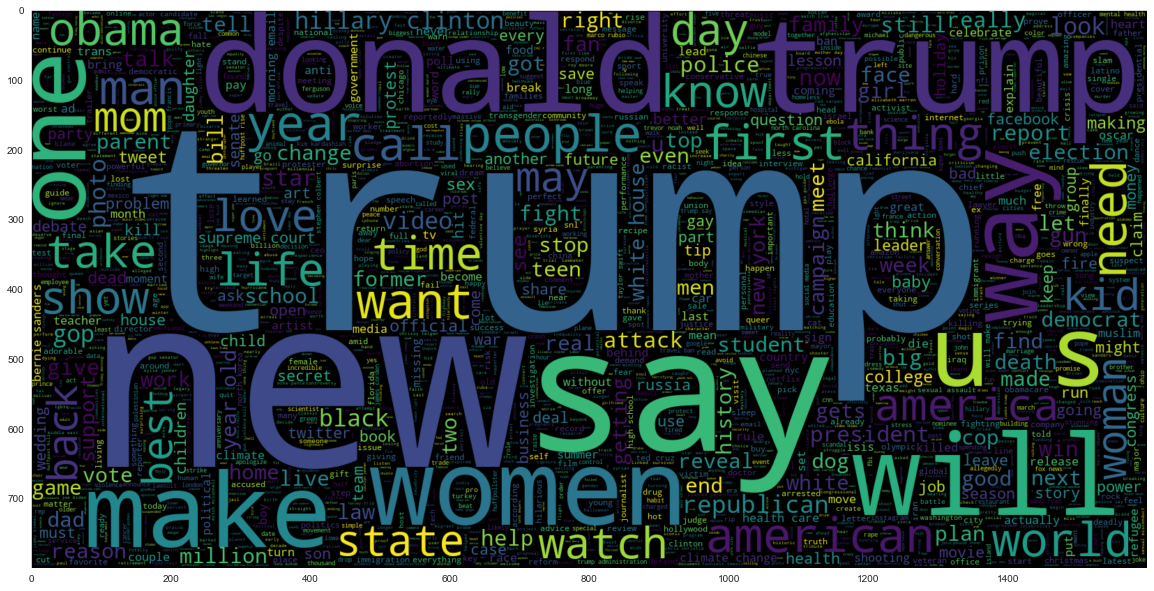

In [ ]:
# Text that is Not Sarcastic
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcasm[sarcasm.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

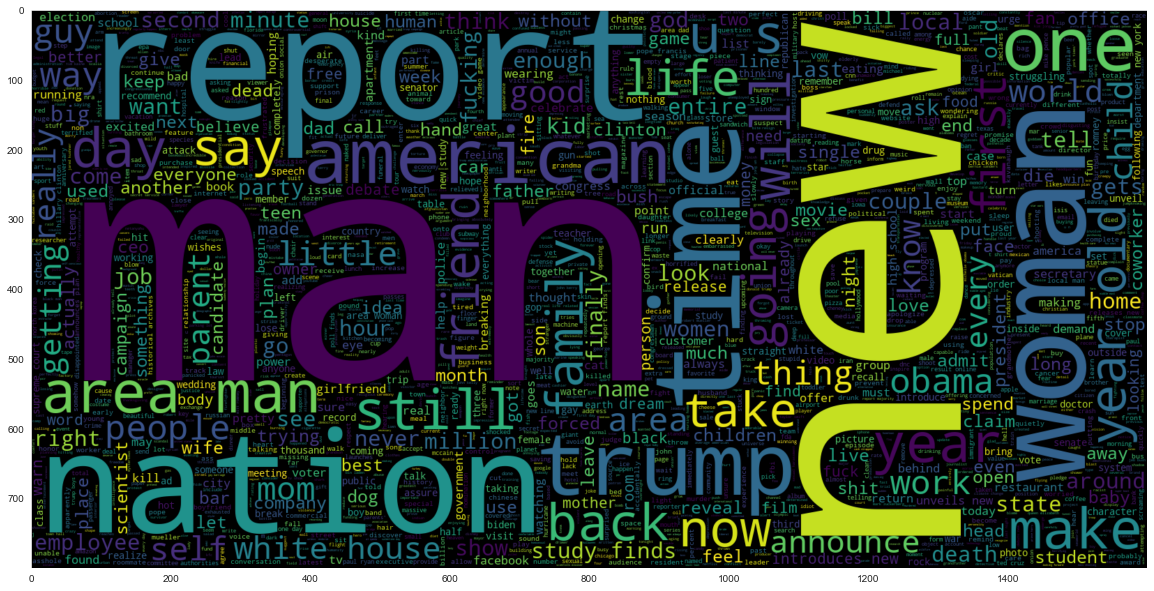

In [ ]:
# Text that is Sarcastic
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(sarcasm[sarcasm.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

# Removing punctuation

In [ ]:
import string

def no_punctuation(text):
    no_punc = "".join([i for i in text if i not in string.punctuation])
    return no_punc

In [ ]:
sarcasm['headline'] = sarcasm['headline'].apply(lambda x : no_punctuation(x))
sarcasm['headline'].head(10)

0                             thirtysomething scientists unveil doomsday clock of hair loss
1             dem rep totally nails why congress is falling short on gender racial equality
2                                          eat your veggies 9 deliciously different recipes
3                                      inclement weather prevents liar from getting to work
4                               mother comes pretty close to using word streaming correctly
5                                                                      my white inheritance
6                                                5 ways to file your taxes with less stress
7    richard bransons globalwarming donation nearly as much as cost of failed balloon trips
8                 shadow government getting too large to meet in marriott conference room b
9                                                        lots of parents know this scenario
Name: headline, dtype: object

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
sarcasm['headline'] = sarcasm['headline'].apply(lambda x : tokenizer.tokenize(x.lower()))
sarcasm['headline'].head(10)

0                                 [thirtysomething, scientists, unveil, doomsday, clock, of, hair, loss]
1            [dem, rep, totally, nails, why, congress, is, falling, short, on, gender, racial, equality]
2                                               [eat, your, veggies, 9, deliciously, different, recipes]
3                                          [inclement, weather, prevents, liar, from, getting, to, work]
4                                  [mother, comes, pretty, close, to, using, word, streaming, correctly]
5                                                                               [my, white, inheritance]
6                                                   [5, ways, to, file, your, taxes, with, less, stress]
7    [richard, bransons, globalwarming, donation, nearly, as, much, as, cost, of, failed, balloon, tr...
8                 [shadow, government, getting, too, large, to, meet, in, marriott, conference, room, b]
9                                                      

# remove_stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def remove_stopwords(text):
    text=[word for word in text if word not in stopwords.words('english')]
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kukumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
sarcasm['headline'] = sarcasm['headline'].apply(lambda x : remove_stopwords(x))
sarcasm['headline'].head(10)

0                          [thirtysomething, scientists, unveil, doomsday, clock, hair, loss]
1              [dem, rep, totally, nails, congress, falling, short, gender, racial, equality]
2                                          [eat, veggies, 9, deliciously, different, recipes]
3                                         [inclement, weather, prevents, liar, getting, work]
4                           [mother, comes, pretty, close, using, word, streaming, correctly]
5                                                                        [white, inheritance]
6                                                        [5, ways, file, taxes, less, stress]
7    [richard, bransons, globalwarming, donation, nearly, much, cost, failed, balloon, trips]
8                   [shadow, government, getting, large, meet, marriott, conference, room, b]
9                                                             [lots, parents, know, scenario]
Name: headline, dtype: object

# WordNetLemmatizer

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmalize(text):
    lem_lext = " ".join([lemmatizer.lemmatize(word) for word in text])
    return lem_lext

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kukumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
sarcasm['headline'] = sarcasm['headline'].apply(lambda x : lemmalize(x))
sarcasm['headline'].head(10)

0                       thirtysomething scientist unveil doomsday clock hair loss
1              dem rep totally nail congress falling short gender racial equality
2                                       eat veggie 9 deliciously different recipe
3                                    inclement weather prevents liar getting work
4                         mother come pretty close using word streaming correctly
5                                                               white inheritance
6                                                        5 way file tax le stress
7    richard bransons globalwarming donation nearly much cost failed balloon trip
8                 shadow government getting large meet marriott conference room b
9                                                        lot parent know scenario
Name: headline, dtype: object

In [ ]:
sarcastic = sarcasm['headline'].loc[sarcasm['is_sarcastic'] == 1]
acclaim = sarcasm['headline'].loc[sarcasm['is_sarcastic'] == 0]

In [ ]:
sarcastic.reset_index(inplace = True, drop = True)
acclaim.reset_index(inplace = True, drop = True)

In [ ]:
sarcastic.head(),acclaim.head()

(0                       thirtysomething scientist unveil doomsday clock hair loss
 1                                    inclement weather prevents liar getting work
 2                         mother come pretty close using word streaming correctly
 3    richard bransons globalwarming donation nearly much cost failed balloon trip
 4                 shadow government getting large meet marriott conference room b
 Name: headline, dtype: object,
 0    dem rep totally nail congress falling short gender racial equality
 1                             eat veggie 9 deliciously different recipe
 2                                                     white inheritance
 3                                              5 way file tax le stress
 4                                              lot parent know scenario
 Name: headline, dtype: object)

# Create a Bag of Words

In [ ]:
# Create two objects X and y. X will be the 'headline' column of sarcasm dataframe and y will 
# be the 'is_sarcastic' column of yelp. create a CountVectorizer object and split the data into training 
# and testing sets. Train a MultinomialNB model for classifying the headlines and Display the confusion Matrix 

In [ ]:
count_vec = CountVectorizer()
bow = count_vec.fit_transform(sarcasm['headline'])
bow = np.array(bow.todense())

In [ ]:
X = bow
y = sarcasm['is_sarcastic']

# Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y)

# Fit the model

In [ ]:
# Fit the model
model = MultinomialNB().fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model performance

In [ ]:
# Evaluate model performance
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print('ROC AUC:', roc_auc_score(y_test, y_pred))

Accuracy: 0.8051479152108083
F1 score: 0.8042266122275417
ROC AUC: 0.8037011437496193


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      4496
           1       0.81      0.77      0.79      4090

    accuracy                           0.81      8586
   macro avg       0.81      0.80      0.80      8586
weighted avg       0.81      0.81      0.80      8586



# confusion matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

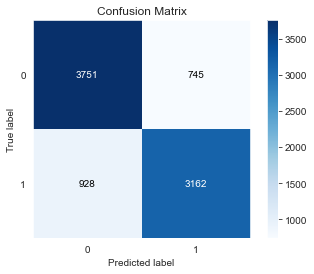

In [ ]:
# Constructing the confusion matrix.
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

# Where did it go wrong? - Observing the prediction of the model. 

In [ ]:
#Where did it go wrong?
results = pd.DataFrame(data={'predicted': y_pred, 'actual': y_test})
predictions = results.join(sarcasm)

In [ ]:
def is_correct(predicted, actual):
    if predicted == actual:
        return True
    else:
        return False

predictions['correct'] = predictions.apply(lambda x: is_correct(x.predicted, x.actual), axis=1)
predictions = predictions[['headline','predicted','actual','correct']]

In [ ]:
predictions[predictions['correct']==False].sample(10)

,headline,predicted,actual,correct
17676,defend humanity,1,0,False
25537,jessica simpson vision blue date night husband eric johnson,1,0,False
14160,u military lauded creating genderneutral killing field,0,1,False
11281,report way nation pay attention climate change julia robert dy hurricane,0,1,False
15725,baseball slugger pace hit 60 woman,0,1,False
6639,facebook google whatsapp plan increase encryption user data,1,0,False
3811,seymour hersh uncovers new thing sad think,0,1,False
2335,netflix gently reminds arrested development fan new episode show wont actually solve world problem,0,1,False
25043,federal judge pencil blocking trump unconstitutional executive order monthly schedule,0,1,False
12783,man show gun alton sterling memorial,1,0,False


# HMM POS tagging on the first 4 rows of ‘headline’

In [ ]:
# pip install C:\Temp\spacy\en_core_web_sm-3.0.0.tar.gz --user
# pip install C:\Temp\spacy\en_core_web_sm-3.0.0-py3-none-any.whl --user
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def posTagging(text):
    doc = nlp(text)
    #Tokenization
    [token.text for token in doc]
    # POS tagging    
    for token in doc:
        print (token.text, token.pos_, token.tag_)


In [ ]:
for i in range(4):
    print(i+1, ": ", sarcasm['headline'][i], "\n")
    print("************POS Tag***************")
    print("\n")
    posTagging(sarcasm['headline'][1])
    print("\n")


1 :  thirtysomething scientist unveil doomsday clock hair loss 

************POS Tag***************


dem NOUN NN
rep NOUN NN
totally ADV RB
nail NOUN NN
congress NOUN NN
falling VERB VBG
short ADJ JJ
gender NOUN NN
racial ADJ JJ
equality NOUN NN


2 :  dem rep totally nail congress falling short gender racial equality 

************POS Tag***************


dem NOUN NN
rep NOUN NN
totally ADV RB
nail NOUN NN
congress NOUN NN
falling VERB VBG
short ADJ JJ
gender NOUN NN
racial ADJ JJ
equality NOUN NN


3 :  eat veggie 9 deliciously different recipe 

************POS Tag***************


dem NOUN NN
rep NOUN NN
totally ADV RB
nail NOUN NN
congress NOUN NN
falling VERB VBG
short ADJ JJ
gender NOUN NN
racial ADJ JJ
equality NOUN NN


4 :  inclement weather prevents liar getting work 

************POS Tag***************


dem NOUN NN
rep NOUN NN
totally ADV RB
nail NOUN NN
congress NOUN NN
falling VERB VBG
short ADJ JJ
gender NOUN NN
racial ADJ JJ
equality NOUN NN




In [ ]:
from spacy import displacy
# dependency visualizer
def dependency_visualizer(text):
    doc = nlp(text)
    displacy.render(doc, style="dep", jupyter=True)
    

In [ ]:
for i in range(4):
     dependency_visualizer(sarcasm['headline'][i])

In [ ]:
************** END ******************